# PT2 parameter Analysis
### Structure
* Imports
    * Libraries: necessary Python Libraries
    * MAT data imports: Importing the estimated from the files generated in MATLAB.
* Calculations
    * Accuracy Metric: Measures how well the estimated PT2 model fits the real data 
    * PT2 properties: Calculation of Peak time, settling time and overshoot
* Filtering: Filtering out parameter outliers
* Representation: Visualized the data for analysis
    * Overall: All of the filtered data
    * Per Driver: Sorting dataset by driver only
    * Per Velocity Class: Sorting by Velocity Class only
    * Per Driver Per Velocity Class
    * 2 drivers compared
### Attention:
* Make sure to change all of the paths in the file (in the Runnables) so it can run on your system.
    * Default saves to: "C:/git/kdp_hlb_evalframework/_temp/"

# Imports

## Libraries

In [3]:
import pandas as pd
import os
import json
import math
import numpy as np
from scipy.io import loadmat
from scipy import signal
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import  PCA
from sklearn import metrics
import seaborn as sns
import dtw

seed = 696969

## MAT data

### Methods

* get_speedup_reason(trip_name, speedup_index)
    * Extracts the driving event reason list from the info json file corresponding to a trip
    * Inputs: 
        * trip_name (string) -- name of the trip that is analyzed e.g. "14_20210719_1626665410733632_CT6_AVT_V3_export" 
        * speedup_index (int) -- index of the speedup in the trip (trip has multiple speedups, this tells us which one it is)
    * Outputs:
        * returns a list containing the driving event reasons extracted in "driving_event_metadata_analysis.py"
* speedup_length_filter(trip_name, speedup_index)
    * Filters out extracted speedup that are too long in terms of time 
    * Inputs: 
        * trip_name (string) -- name of the trip that is analyzed e.g. "14_20210719_1626665410733632_CT6_AVT_V3_export" 
        * speedup_index (int) -- index of the speedup in the trip (trip has multiple speedups, this tells us which one it is)
    * Outputs:
        * returns False if the speedup is too long to be analyzed for the PT2 model
        * returns True otherwise
* get_speedup_parameters(start, end, mat_dict, df)
    * Extracts the PT2 parameters out of the MAT file crated during the MATLAB parameter estimation.
    * Inputs:
        * start (int) -- index of the first trip in trip_info that is analyzed
        * end (int) -- index of the last trip in trip_info that is analyzed
        * mat_dict (dictionary) -- The MAT file where the PT2 parameters are saved as a dictionary
        * trip_infos (pandas DataFrame) -- maps the trip_name to the driver_id, includes information about how many speedups a trip has and serves as an overview of all the speedups whose parameters can be estimated.
    * Outputs:
        * speedup_parameters (numpy array) -- parameters [K, D, w0] for all speedups
        * parameters_df (pandas DataFrame): The DataFrame has several columns
            * "trip_name" (string) -- name of the trip that is analyzed
            * "speedup_index" (int) -- index of the speedup that is analyzed within the trip
            * "driver_id" (string) -- name of the driver specified in "ArchiveCheck_update.csv"
            * "velocity_class" (string) -- velocity category extracted as a driving event reason during the Metadata analysis. Possible Categories are:
                * "zero_to_low_speed_up"
                * "zero_to_mid_speed_up"
                * "zero_to_high_speed_up",
                * "low_to_low_speed_up"
                * "low_to_mid_speed_up"
                * "low_to_high_speed_up",
                * "mid_to_mid_speed_up"
                * "mid_to_high_speed_up"
                * "high_to_high_speed_up",
            * "highway_driving" (boolean) -- whether or not any section during the speedup time sequence had a "highway" signal active.
            * "K" (float) -- Control Gain of the transfer function of the PT2 model, but set to 1.0
            * "D" (float) --  damping parameter of the estimated PT2 model
            * "w0" (float) -- natural frequency of the estimated PT2 model and it represents the frequency of the oscillation of the system without damping 

In [2]:
def get_speedup_reason(trip_name, speedup_index):
    info_path = "C:/git/kdp_hlb_evalframework/_temp/driving_event_window_info/" + trip_name + "_info.json"
    with open(info_path, 'r') as open_file:
        read_list = json.load(open_file)
    for window_dict in read_list:
        if window_dict['data'] == 'speed_up'+str(speedup_index)+'.csv':
            return window_dict['driving_event_reason']

In [3]:
def speedup_length_filter(trip_name, speedup_index):
    MAX_SPEEDUP_LENGTH = 750
    info_path = "C:/git/kdp_hlb_evalframework/_temp/driving_event_window_info/" + trip_name + "_info.json"
    with open(info_path, 'r') as open_file:
        read_list = json.load(open_file)
    for window_dict in read_list:
        if window_dict['data'] == 'speed_up'+str(speedup_index)+'.csv':
            length = int(window_dict['length'])
            if length > MAX_SPEEDUP_LENGTH:
                return False
            else:
                return True

In [4]:
def get_speedup_parameters(start, end, mat_dict, df):
    y = []
    parameters_df = pd.DataFrame(columns=["K", "w0", "D", "trip_name", "speedup_index", "driver_id", "velocity_class", "highway_driving"])
    velocity_classes = ["zero_to_low_speed_up", "zero_to_mid_speed_up", "zero_to_high_speed_up",
                "low_to_low_speed_up", "low_to_mid_speed_up", "low_to_high_speed_up",
                "mid_to_mid_speed_up", "mid_to_high_speed_up", "high_to_high_speed_up",
                ]
    end = min(end, trip_infos.shape[0])
    for i in range(start, end):
        number_of_speedups = df['number_of_speedups'][i]
        trip_name = df['trip_name'][i]
        driver_id = df['subject_id'][i]
        for j in range(number_of_speedups-1):
            parameter_string = "trip{index}_speedup_{speedup_index}_parameter".format(index = i, speedup_index = j)
            parameters = mat_dict[parameter_string][0]
            reasons = get_speedup_reason(trip_name=trip_name, speedup_index=j)
            velocity_class = "unknown"
            highway_driving = False
            for reason in reasons:
                if reason in velocity_classes:
                    velocity_class = reason 
            if "highway_driving" in reasons:
                highway_driving = True
            #parameters are [K, w0, D]
            if not "turn" in reasons and speedup_length_filter(trip_name=trip_name, speedup_index=j):
                y.append(parameters)
                parameters_df.loc[-1] = [parameters[0], parameters[1], parameters[2], trip_name, j, driver_id, velocity_class, highway_driving]
                parameters_df.index = parameters_df.index + 1
    y = np.array(y)
    return y, parameters_df

### Runnables

In [5]:
save_path = "C:/Users/scs3yh/Documents/documentation_materials/documentation_images/ACC/PT2/"
plt.rcParams['figure.figsize'] = [15, 8]
number_of_trips = 3305

In [6]:
signal_profiles_path = "C:/git/kdp_hlb_evalframework/_python_evaluation/acceleration_learning/acceleration_learning_signal_profiles.json"
with open(signal_profiles_path, 'r') as open_file:
    all_signal_profiles = json.load(open_file)
signal_profile_name = "Cadillac_CT6"#"Lane_Change_validator"#
signal_profile = all_signal_profiles[signal_profile_name]

In [7]:
source_path = "C:/git/kdp_hlb_evalframework/_temp/"
data_path = source_path + "driving_event_window_data/"
input_postfix = "PT2_2023_07_11"#"PT2_2023_06_29"#"_jp_extreme_experiment"#
output_postfix = "PT2_2023_08_21"#"_jp_extreme_experiment"#
trip_infos = pd.read_csv(source_path + "trip_infos_{input_postfix}.csv".format(input_postfix = input_postfix))
mat_file_name = source_path + "_all_parameters_" + input_postfix + ".mat"
mat_dict = loadmat(mat_file_name)

In [8]:
speedup_parameters, parameters_df = get_speedup_parameters(0,number_of_trips, mat_dict, trip_infos)

In [9]:
speedup_parameters.shape

(26939, 3)

# Calculations

## Accuracy Metric (Area under the curve)

### Methods

* get_pt2_signal(parameters)
    * calculates and returns the pt2 signal based on the parameters
    * Inputs: 
        * "K" (float) -- Control Gain of the transfer function of the PT2 model, but set to 1.0
        * "D" (float) --  damping parameter of the estimated PT2 model
        * "w0" (float) -- natural frequency of the estimated PT2 model and it represents the frequency of the oscillation of the system without damping 
    * Outputs:
        * t (numpy array) -- time of the pt2 model with the parameters
        * y (numpy array) -- simulated normalized velocity based on the pt2 model with the parameters
* find_gain_velocity(long_velocity)
    * calculates the gain that the pt2 model would use
    * Inputs: 
        * long_velocity (numpy array) -- longitudinal velocity signal of the speedup sequence
    * Outputs:
        * Kp -- difference between starting and ending velocity during the speedup sequence
* get_velocity_signal(data_path, trip_name, speedup_index)
    * extracts the time and velocity signal from the extracted sequence
    * Inputs: 
        * data_path (string) -- path to the folder that includes the per trip folders that include the speedup window data as csv
        * trip_name (string) -- name of the trip that is analyzed e.g. "14_20210719_1626665410733632_CT6_AVT_V3_export" 
        * speedup_index (int) -- index of the speedup in the trip (trip has multiple speedups, this tells us which one it is)
    * Outputs:
        * t (numpy array) -- time of the extracted sequence
        * y (numpy array) -- normalized longitudinal velocity of the extracted sequence
* get_signals(parameters_df, index)
    * returns the normalized and resampled signals for accuracy analysis
    * Inputs: 
        * parameters_df (pandas DataFrame) -- DataFrame that includes all speedups synchronized with its parameters 
        * index (int) -- index of the speedup in question in parameters_df
    * Outputs:
        * t_display (numpy array) -- resampled time signal (100)
        * y_real (numpy array) -- normalized and resampled longitudinal velocity of the extracted sequence
        * y_pt2 (numpy array) -- normalized and resampled modeled longitudinal velocity with the pt2 model
        * Kp (type) -- difference between starting and ending velocity during the speedup sequence
* get_metrics(y_real, y_pt2)
    * metrics are calculated that may indicate the accuracy of the modeling compared to the extracted sequences
    * Inputs: 
        * y_real (numpy array) -- normalized and resampled longitudinal velocity of the extracted sequence
        * y_pt2 (numpy array) -- normalized and resampled modeled longitudinal velocity with the pt2 model
    * Outputs:
        * trapz_integral (float) -- Integral (Area under the curve) of the absolute difference function between y_real and y_pt2 
        * mae (float) -- Mean Absolute Error between y_real and y_pt2
        * mse (float) -- Mean Squared Error between y_real and y_pt2

In [18]:
def get_pt2_signal(K, w0, D):
    P2 = signal.lti([K],[1/pow(w0, 2), 2*D/w0, 1])
    t, y = signal.step(P2)
    return t, y

In [19]:
def find_gain_velocity(long_velocity):
    return long_velocity[len(long_velocity)-1] - long_velocity[0]

In [20]:
def get_velocity_signal(data_path, trip_name, speedup_index, signal_profile):
    data_df = pd.read_csv(os.path.join(str(data_path), str(trip_name), "speed_up{index}.csv".format(index = speedup_index)))
    y = data_df[signal_profile["Longitudinal_Velocity"]].values
    t = np.arange(0, len(y))
    return t, y

In [21]:
def get_signals(parameters_df, trip_name, speedup_index, signal_profile):
    t_real, long_velocity = get_velocity_signal(data_path, trip_name=trip_name, speedup_index=speedup_index, signal_profile=signal_profile)
    #project long velocity to start from 0 like pt2
    Kp = find_gain_velocity(long_velocity)
    y_real = (long_velocity - long_velocity[0]) / Kp    
    #get a pt2 signal with the terminal velocity as a gain
    df = parameters_df.iloc[(parameters_df.trip_name.values == trip_name) & (parameters_df.speedup_index.values == speedup_index)]
    t_pt2, y_pt2 = get_pt2_signal(K=1.0, w0=df.w0.values[0], D=df.D.values[0])
    #resample the pt2 model but without the edge noise
    y_pt2 = np.pad(y_pt2, (15, 15), mode='edge')
    padding_length = math.floor(0.15*len(long_velocity))
    y_real = np.pad(y_real, (padding_length, padding_length), mode='edge')
    y_pt2 = signal.resample(y_pt2, 130)
    y_real = signal.resample(y_real, 130)
    padding_length_reduced = 15
    y_pt2 = y_pt2[padding_length_reduced:len(y_pt2)-padding_length_reduced]
    y_real = y_real[padding_length_reduced:len(y_real)-padding_length_reduced]
    t_display = np.arange(0,100)
    return t_display, y_real, y_pt2, Kp

In [22]:
def get_metrics(y_real, y_pt2):
    min_signal = abs(y_pt2-y_real)
    trapz_integral = np.trapz(min_signal, dx=1)
    return trapz_integral

### Runnables

#### Example

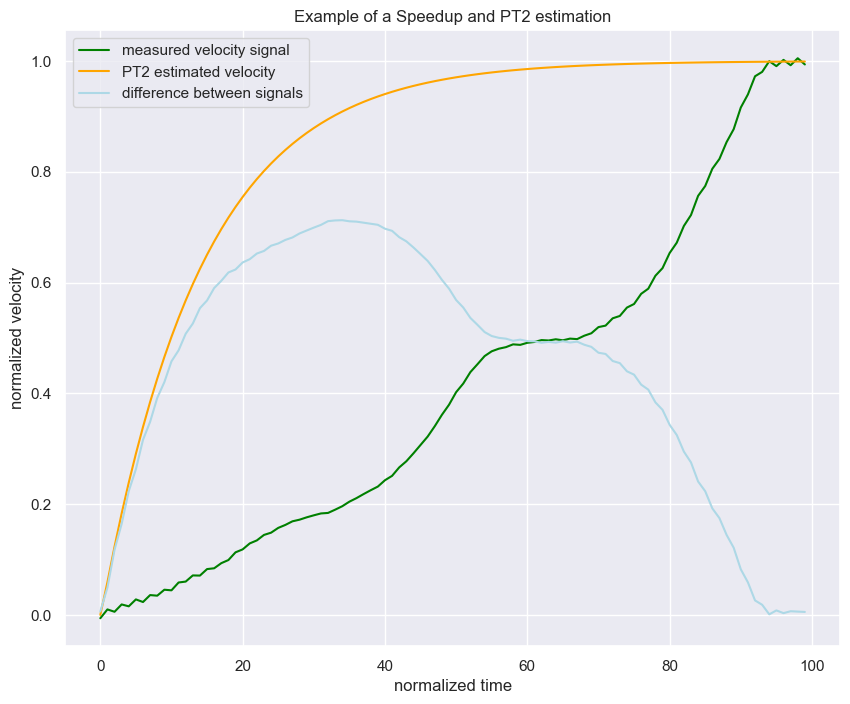

45.04038223121294


In [93]:
trip_name = "OD_ZJP_G02_20230807_164449__DASy"
sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 8]
t_real, y_real, y_pt2, Kp = get_signals(parameters_df=parameters_df, trip_name=trip_name, speedup_index=0, signal_profile=signal_profile)
trapz_auc = get_metrics(y_real, y_pt2)
min_signal_norm = abs(y_pt2-y_real)
plt.plot(t_real, y_real, color='green', label="measured velocity signal")
plt.plot(t_real, y_pt2, color='orange', label="PT2 estimated velocity")
plt.plot(t_real, min_signal_norm, color='lightblue', label="difference between signals")
plt.legend()
plt.ylabel("normalized velocity")
plt.xlabel("normalized time")
plt.title("Example of a Speedup and PT2 estimation")
plt.savefig(save_path + trip_name + "speedup0_PT2.png")
plt.show()
print(trapz_auc)

#### Calculating accuracy for entire dataset and creating a summary

In [23]:
accuracy_summary_df = pd.DataFrame(columns=["trip_name","speedup_index","driver_id","velocity_class","highway_driving","K","w0","D","trapz_integral"])
for i in range(parameters_df.shape[0]):
    t_real, y_real, y_pt2, Kp = get_signals(parameters_df=parameters_df, trip_name=parameters_df.trip_name.values[i],speedup_index=parameters_df.speedup_index.values[i], signal_profile=signal_profile)
    trapz_integral = get_metrics(y_real, y_pt2)
    accuracy_summary_df.loc[-1] = [parameters_df.trip_name[i], parameters_df.speedup_index[i], parameters_df.driver_id[i], parameters_df.velocity_class[i], parameters_df.highway_driving[i], 
                                Kp, parameters_df.w0[i], parameters_df.D[i], trapz_integral]
    accuracy_summary_df.index = accuracy_summary_df.index + 1
accuracy_summary_df

,trip_name,speedup_index,driver_id,velocity_class,highway_driving,K,w0,D,trapz_integral
26938,14_20210726_1627299639420402_CT6_AVT_V3_export,22,2016k_203,low_to_low_speed_up,False,7.3125,0.915636,0.991485,41.710734
26937,14_20210726_1627299639420402_CT6_AVT_V3_export,21,2016k_203,low_to_low_speed_up,False,3.0625,0.214860,0.904060,14.743385
26936,14_20210726_1627299639420402_CT6_AVT_V3_export,20,2016k_203,low_to_low_speed_up,False,8.6250,0.262301,0.999900,30.453616
26935,14_20210726_1627299639420402_CT6_AVT_V3_export,19,2016k_203,zero_to_low_speed_up,False,2.8125,0.249064,0.684276,45.495962
26934,14_20210726_1627299639420402_CT6_AVT_V3_export,18,2016k_203,low_to_low_speed_up,False,4.4375,0.499105,0.712218,24.859404
...,...,...,...,...,...,...,...,...,...
4,10_20180828_1535498983886417_CT6_AVT_V3_export,5,2016k_099,low_to_mid_speed_up,False,4.6250,0.506878,0.732927,35.213279
3,10_20180828_1535498983886417_CT6_AVT_V3_export,4,2016k_099,low_to_mid_speed_up,False,4.0000,0.157385,0.340349,23.517274
2,10_20180828_1535498983886417_CT6_AVT_V3_export,3,2016k_099,low_to_low_speed_up,False,2.5625,0.407751,0.673496,16.498465
1,10_20180828_1535498983886417_CT6_AVT_V3_export,1,2016k_099,low_to_low_speed_up,False,4.3750,0.996162,0.999900,23.554495


In [95]:
accuracy_summary_df.to_csv(source_path + "accuracy_summary_velocity_signal_vs_PT2__full_normalized.csv")

(26820, 9)
(26820, 9)


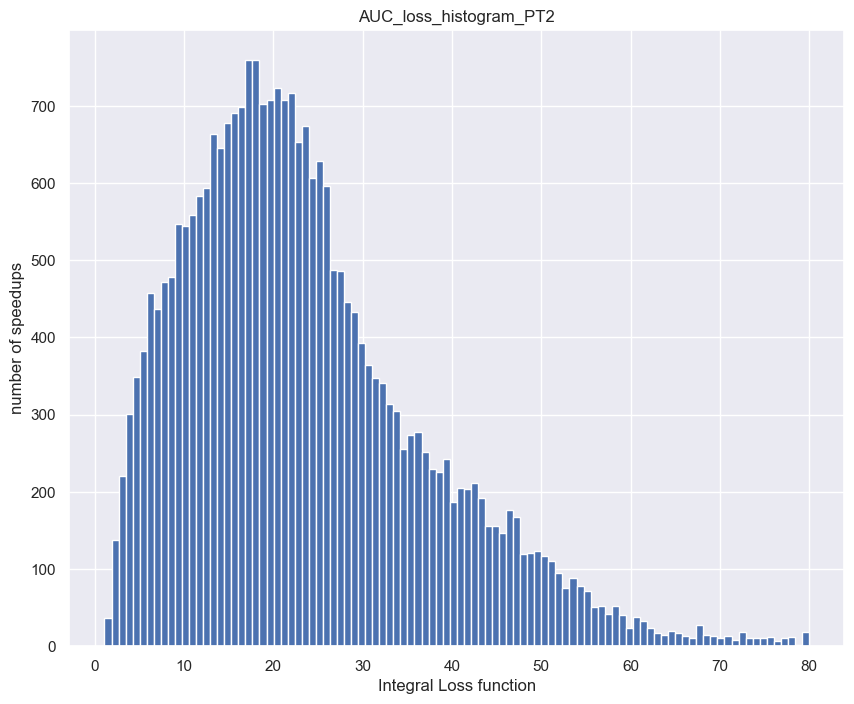

In [30]:
sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 8]
print(accuracy_summary_df.shape)
accuracy_summary_df = accuracy_summary_df.loc[accuracy_summary_df.trapz_integral.values < 80]
print(accuracy_summary_df.shape)
plt.hist(accuracy_summary_df["trapz_integral"].values, bins=100)
plt.title("AUC_loss_histogram_PT2")
plt.xlabel("Integral Loss function")
plt.ylabel("number of speedups")
plt.savefig(save_path+"AUC_loss_histogram_PT2.png")
plt.show()

## PT2 properties (Peak Time, Overshoot, Settling Time)

### Methods

* calculate_properties(y, df)
    * action
    * Inputs: 
        * y (numpy array) -- array of shape (n,3) that includes all of the estimated PT2 parameters
        * df (pandas dataframe) -- DataFrame with the parameters mapped to the trip_name and speedup_index created during "get_speedup_parameters"
    * Outputs:
        * properties (numpy array) --  the corresponding PT2 properties Peak Time (Tp), Overshoot (OS) and Settling Time (Ts) in an array of shape (n,3)
        * properties_df (pandas DataFrame) -- DataFrame with the parameters mapped to the trip_name and speedup_index created during "get_ca_pt2_parameters" and added to that the corresponding PT2 properties Peak Time (Tp), Overshoot (OS) and Settling Time (Ts)

In [28]:
def calculate_properties(y, df):
    properties = []
    parameters_df = pd.DataFrame(columns=[ "trip_name", "speedup_index", "driver_id","velocity_class","highway_driving","K", "w0", "D","Tp","OS","Ts"])
    for i, (Di, w0i) in enumerate(zip(df.D.values, df.w0.values)):
        if Di < 1 and Di > 0.3 and w0i >= 0 and w0i <= 1:
            Tp = math.pi/(w0i*math.sqrt(1-Di**2))
            OS = 100*math.exp(-(Di*math.pi)/(math.sqrt(1-Di**2)))
            Ts = 4/(w0i*Di)
            properties.append([Tp, OS, Ts])
            parameters_df.loc[-1] = [df.iloc[i,3], df.iloc[i,4], df.iloc[i,5], df.iloc[i,6], df.iloc[i,7], df.iloc[i,0], df.iloc[i,1], df.iloc[i,2], Tp, OS, Ts]
            parameters_df.index = parameters_df.index + 1
    properties = np.array(properties)
    return properties, parameters_df

### Runnables

In [29]:
speedup_properties, parameters_df = calculate_properties(speedup_parameters, parameters_df)

# Filtering

### Methods

* outlier_filter(speedup_parameters, parameters_df)
    * filters any speedups out of the dataset where Tp1 is too large 
    * Inputs: 
        * speedup_parameters (numpy array) -- parameters [K, Tp1] for all speedups
        * parameters_df (pandas DataFrame): The DataFrame has several columns
            * "trip_name" (string) -- name of the trip that is analyzed
            * "speedup_index" (int) -- index of the speedup that is analyzed within the trip
            * "driver_id" (string) -- name of the driver specified in "ArchiveCheck_update.csv"
            * "velocity_class" (string) -- velocity category extracted as a driving event reason during the Metadata analysis. Possible Categories are:
                * "zero_to_low_speed_up"
                * "zero_to_mid_speed_up"
                * "zero_to_high_speed_up",
                * "low_to_low_speed_up"
                * "low_to_mid_speed_up"
                * "low_to_high_speed_up",
                * "mid_to_mid_speed_up"
                * "mid_to_high_speed_up"
                * "high_to_high_speed_up",
            * "highway_driving" (boolean) -- whether or not any section during the speedup time sequence had a "highway" signal active.
                * "K" (float) -- Control Gain of the transfer function of the PT2 model, but set to 1.0
                * "D" (float) --  damping parameter of the estimated PT2 model
                * "w0" (float) -- natural frequency of the estimated PT2 model and it represents the frequency of the oscillation of
    * Outputs:
        * speedup_parameters (numpy array) -- parameters [K, Tp1] for all speedups
        * parameters_df (pandas DataFrame) -- The same DataFrame structure as in the input
* properties_outlier_filter(speedup_properties, df)






In [103]:
# basic parameter filters
def outlier_filter(speedup_parameters, parameters_df):
    speedup_parameters = [yi for yi in speedup_parameters if yi[2] > 0.4]
    speedup_parameters = [yi for yi in speedup_parameters if yi[2] < 1.0]
    speedup_parameters = [yi for yi in speedup_parameters if yi[1] < 1.0]
    parameters_df = parameters_df.loc[parameters_df.D > 0.4]
    parameters_df = parameters_df.loc[parameters_df.D < 1.0]
    parameters_df = parameters_df.loc[parameters_df.w0 < 1.0]
    return np.array(speedup_parameters), parameters_df

In [104]:
# properties filters
def properties_outlier_filter(speedup_properties, df):
    count = [0, 0, 0]
    filtered_speedup_properties = []
    for properties in speedup_properties:
        if properties[0] > 40:
            count[0] += 1
        elif properties[1] > 40:
            count[1] += 1
        elif properties[2] > 40:
            count[2] += 1
        else:
            filtered_speedup_properties.append(properties)
    #print("filtered {Tp} Peak Times,{Os} % Overshoots and {Ts} Settling Times".format(Tp = count[0], Os = count[1], Ts = count[2]))
    df = df.loc[df.Tp < 40]
    df = df.loc[df.OS < 40]
    df = df.loc[df.Ts < 40]
    filtered_speedup_properties = np.array(filtered_speedup_properties)
    return filtered_speedup_properties, df

### Runnables

In [105]:
speedup_parameters, parameters_df = outlier_filter(speedup_parameters, parameters_df)

In [106]:
filtered_speedup_properties, parameters_df = properties_outlier_filter(speedup_properties, parameters_df)

In [107]:
parameters_df.to_csv(source_path + "speedup_parameters_and_properties_"+output_postfix+".csv", index=False)

# Representations

## Methods
* plot_pt2(params, color="blue")
* histogram_plotting(y)
* scatter_plotting(y)
* k_means_scatter(y, n_clusters,seed, title):
* plot_n_centroids(k_means_model, n)
* density_cluster(parameters)

In [2]:
def plot_pt2(params, color="blue"):
    K = params[0]
    w0 = params[1]
    D = params[2]
    P2 = signal.lti([K],[1/pow(w0, 2), 2*D/w0, 1])
    t, y = signal.step(P2)
    plt.plot(t, y, color=color)

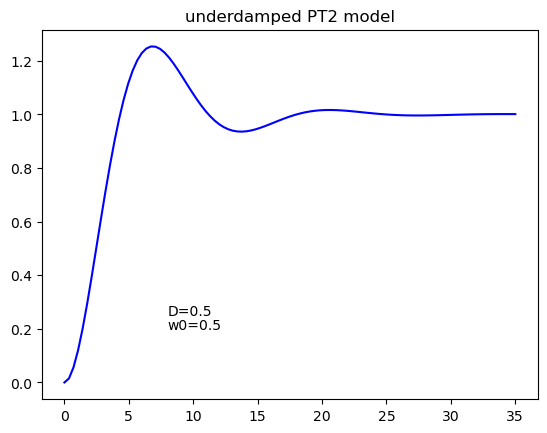

In [14]:
plot_pt2([1,0.5,0.4])
plt.text(s="D=0.5",y=0.25, x=8)
plt.text(s="w0=0.5",y=0.2, x=8)
plt.title("underdamped PT2 model")
plt.show()

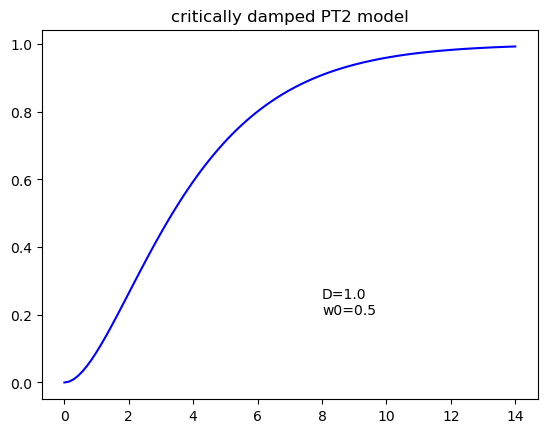

In [13]:
plot_pt2([1,0.5,1])
plt.text(s="D=1.0",y=0.25, x=8)
plt.text(s="w0=0.5",y=0.2, x=8)
plt.title("critically damped PT2 model")
plt.show()

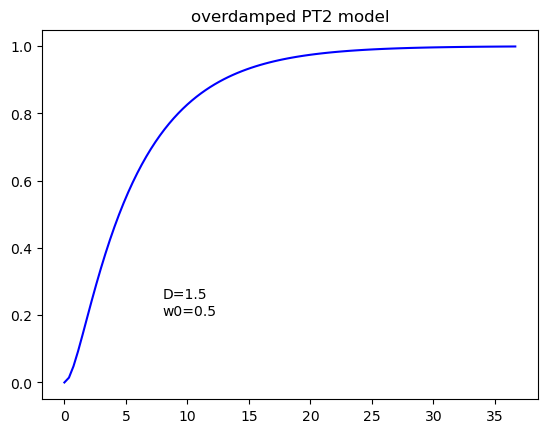

In [15]:
plot_pt2([1,0.5,1.5])
plt.text(s="D=1.5",y=0.25, x=8)
plt.text(s="w0=0.5",y=0.2, x=8)
plt.title("overdamped PT2 model")
plt.show()

In [109]:
def histogram_plotting(y, save_path,title, parameter1=1, parameter2=2, parameter1_name="w0", parameter2_name="D", show_fig=False):
    y = y[:,parameter1:parameter2+1]
    plt.hist(y, bins=30)
    plt.title(title)
    plt.xlabel("parameters")
    plt.ylabel("number of speedups")
    plt.legend([parameter1_name, parameter2_name])
    plt.savefig(save_path + title + ".png")
    plt.show()

In [110]:
def scatter_plotting(y, save_path, title, parameter1=1, parameter2=2, parameter1_name="w0", parameter2_name="D"):
    plt.scatter(y[:,parameter1], y[:,parameter2])
    plt.title(title)
    plt.xlabel(parameter1_name)
    plt.ylabel(parameter2_name)
    plt.savefig(save_path + title + ".png")
    plt.show()

In [111]:
def k_means_scatter(y, n_clusters,seed, title,save_path, parameter1=1, parameter2=2, parameter1_name="w0", parameter2_name="D", show_fig=False):
    x = y[:,[parameter1, parameter2]]
    print(x.shape)
    # Define the model
    kmeans_model = KMeans(init="random", n_clusters=n_clusters, random_state=seed, n_init=3)
    # Fit into our dataset fit
    kmeans_predict = kmeans_model.fit_predict(x)

    color_list = ['red', 'blue', 'green', 'orange', 'purple'] 
    # Visualising the clusters
    for i in range(n_clusters):
        plt.scatter(x[kmeans_predict == i, 0], x[kmeans_predict == i, 1], s = 100, c=color_list[i], label = "cluster {index}".format(index = i))
    # Plotting the centroids of the clusters
    plt.scatter(kmeans_model.cluster_centers_[:, 0], kmeans_model.cluster_centers_[:,1], s = 100, c = "yellow", label = "Centroids")
    
    plt.xlabel(parameter1_name)
    plt.ylabel(parameter2_name)
    plt.legend()
    print("Cluster Centers",parameter1_name,":", str(kmeans_model.cluster_centers_[:, 0]))
    print("Cluster Centers:",parameter2_name,":", str(kmeans_model.cluster_centers_[:, 1]))
    plt.title(title)
    plt.savefig(save_path + title +'.png')
    if show_fig:
        plt.show()
    else:
        plt.close()
    return kmeans_model

In [112]:
def plot_n_centroids(k_means_model, n):
    color_list = ['red', 'blue', 'green', 'orange', 'purple']
    for i in range(n):
        plot_pt2([1,  k_means_model.cluster_centers_[i, 0] , k_means_model.cluster_centers_[i, 1]], color=color_list[i])

In [113]:
def pca_hist(speedup_properties,save_path,postfix,threshold1=-10, threshold2=10, threshold3=50, velocity_class="", driver=""):
    speedup_properties_mod = [1/speedup_properties[:,0], speedup_properties[:,1], 1/speedup_properties[:,2]]
    speedup_properties_mod = np.array(speedup_properties_mod).T
    speedup_properties_mod = [speedup_properties[:,0]-np.mean(speedup_properties[:,0]),speedup_properties[:,1]-np.mean(speedup_properties[:,1]),speedup_properties[:,2]-np.mean(speedup_properties[:,2])]
    speedup_properties_mod = np.array(speedup_properties_mod).T
    pca = PCA(n_components=1)
    pca_result = pca.fit_transform(speedup_properties_mod)
    defense = pca_result[pca_result <= threshold1]
    attack = pca_result[pca_result < threshold3]
    attack = attack[attack > threshold2]
    midfield = pca_result[pca_result <= threshold2]
    midfield = midfield[midfield > threshold1]
    print(defense.shape, midfield.shape, attack.shape)
    plt.hist(defense, color="green", bins=40)
    plt.hist(midfield, color="orange", bins=40)
    plt.hist(attack, color="red", bins=120)
    plt.title("PCA_value_from_step_response_properties_" + velocity_class +" "+ driver)
    plt.savefig(save_path+"/PCA_dynamics_value_histogram_{v_class}_{dr}_{postfix}.png".format(v_class = velocity_class, dr=driver, postfix = postfix))
    plt.show()
    return pca_result, pca.explained_variance_ratio_

In [114]:
def gaussian_mixture_plot(parameters_df, drivers, velocity_class, parameter1, parameter2, n_components):
    my_colors = ['cyan','orange','blue','red']
    fig = plt.figure(figsize = (20, 7))
    ax = fig.subplots(1,2)
    for i, driver in enumerate(two_drivers):
        velocity_class_parameters_df = parameters_df.loc[parameters_df.velocity_class == velocity_class]
        driver_df = velocity_class_parameters_df.loc[velocity_class_parameters_df.driver_id == driver]
        X_train = np.array([driver_df.iloc[:,parameter1], driver_df.iloc[:,parameter2]]).T
        gm = GaussianMixture(n_components=n_components, init_params='k-means++',random_state=0).fit(X_train)
        result = gm.predict(X_train) + i * 5
        #print(gm.means_)
        ax[i].scatter(driver_df.iloc[:,parameter1].values, driver_df.iloc[:,parameter2].values,c=result,alpha=0.4)
        ax[i].scatter(gm.means_[:,0],gm.means_[:,1],color=my_colors[i+2])
        ax[i].set_title(two_drivers[i])
    plt.xlabel(driver_df.iloc[:,parameter1].name)
    plt.ylabel(driver_df.iloc[:,parameter2].name)
    plt.show()

In [115]:
def scatter_plot_2_parameters(list_of_driver_dfs, parameter1, parameter2):
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes()
    for driver_df in list_of_driver_dfs:
        ax.scatter(driver_df.iloc[:,parameter1].values, driver_df.iloc[:,parameter2].values, label=driver_df.iloc[0,2])
    plt.xlabel(driver_df.keys()[parameter1])
    plt.ylabel(driver_df.keys()[parameter2])
    ax.legend()
    plt.show()

## Overall

### Histograms

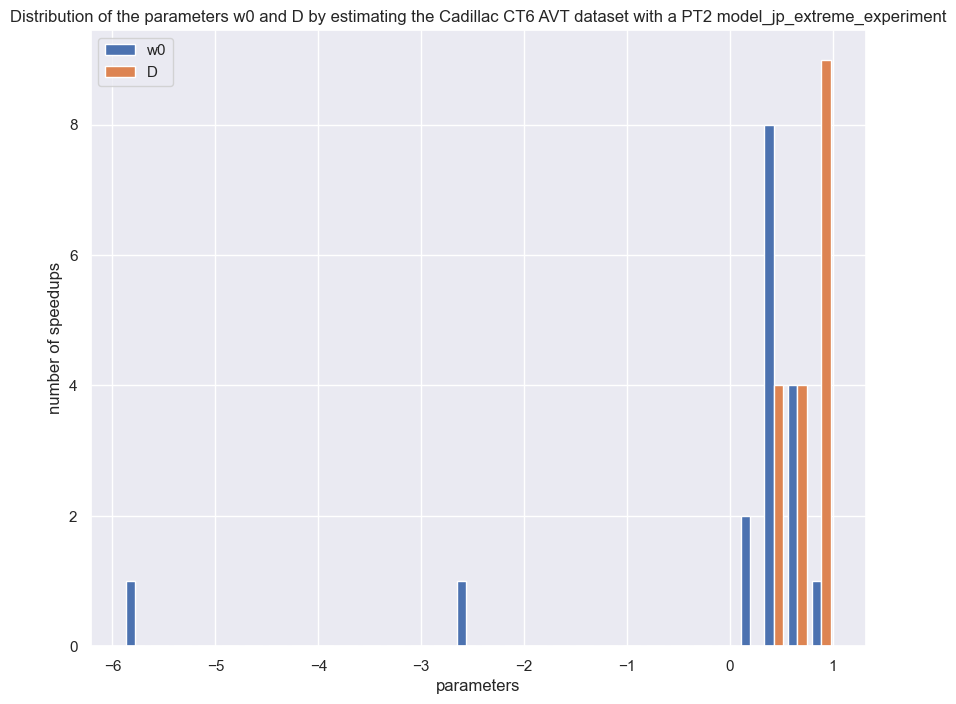

In [116]:
title = "Distribution of the parameters w0 and D by estimating the Cadillac CT6 AVT dataset with a PT2 model" + output_postfix
histogram_plotting(speedup_parameters, save_path,title, show_fig=True)

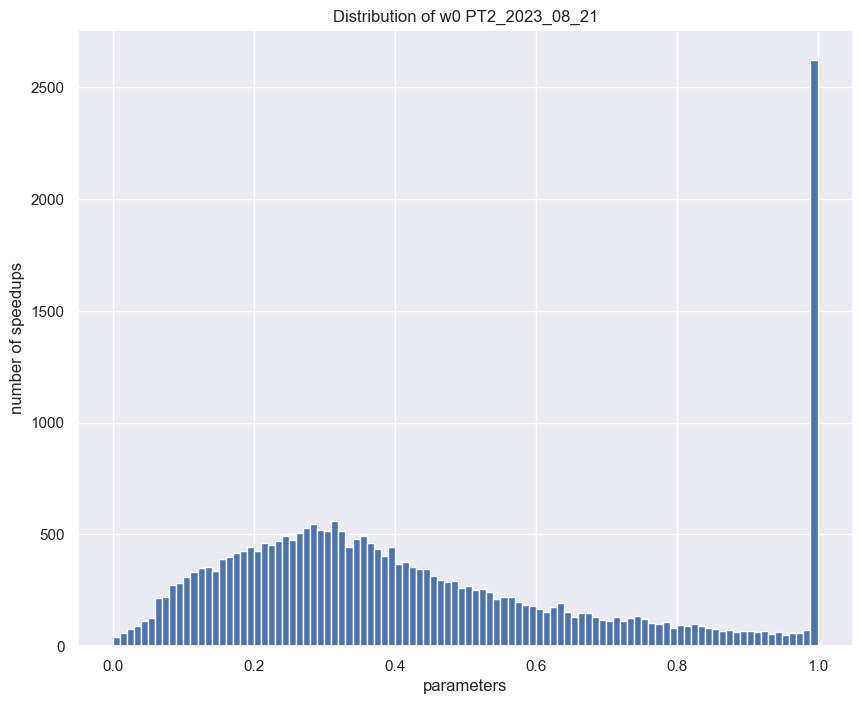

In [14]:
sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 8]
figure_save_path = save_path + "Distribution_of_w0_" + output_postfix +".png"
plt.hist(parameters_df.w0.values, bins=100)
plt.title("Distribution of w0 " + output_postfix)
plt.xlabel("parameters")
plt.ylabel("number of speedups")
plt.savefig(figure_save_path)
plt.show()

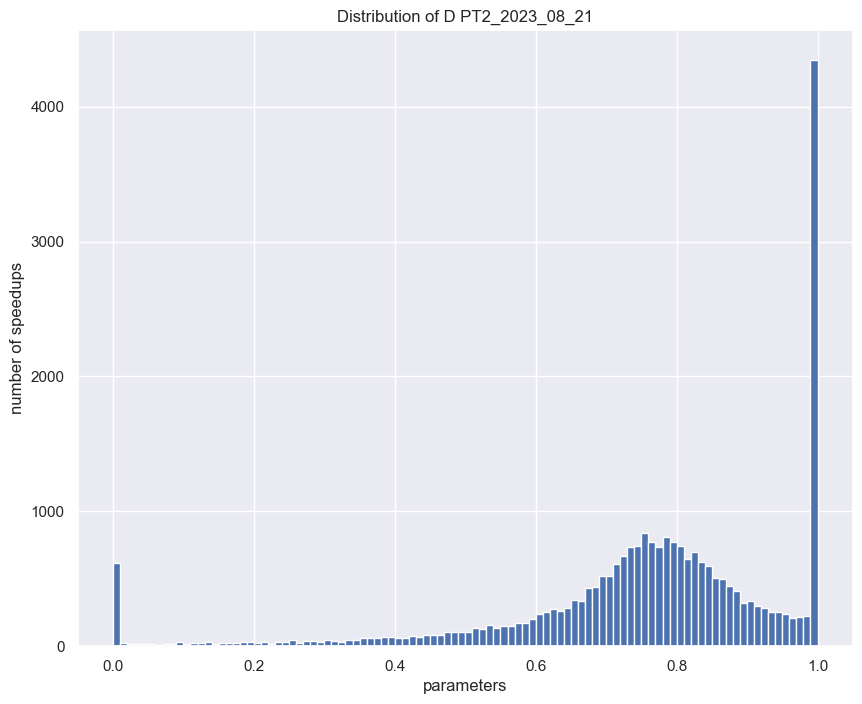

In [15]:
figure_save_path = save_path + "Distribution_of_D_" + output_postfix +".png"
plt.hist(parameters_df.D.values, bins=100)
plt.title("Distribution of D " + output_postfix)
plt.xlabel("parameters")
plt.ylabel("number of speedups")
plt.savefig(figure_save_path)
plt.show()

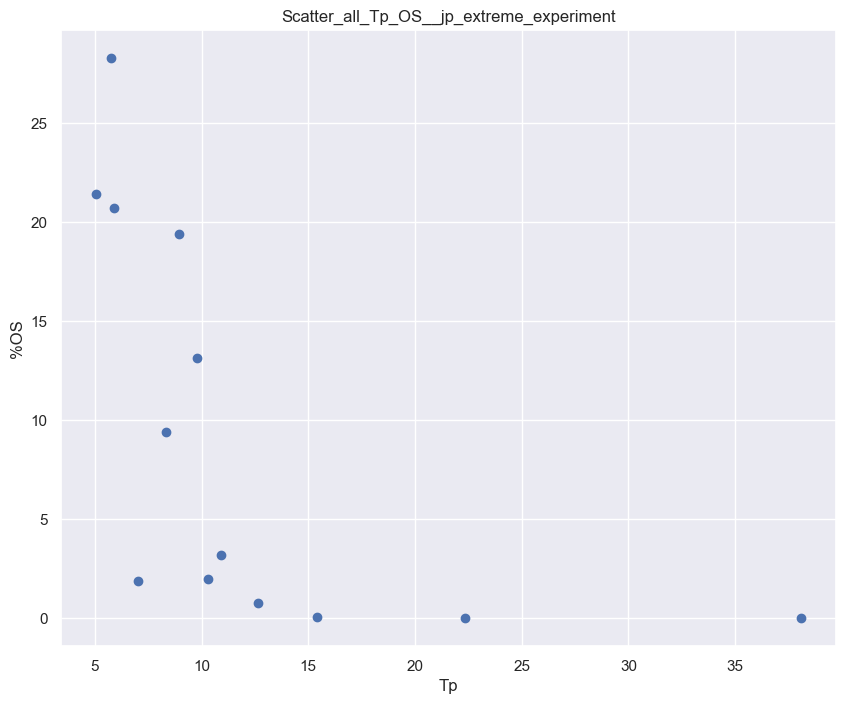

In [117]:
scatter_plotting(filtered_speedup_properties, save_path, title="Scatter_all_Tp_OS_"+output_postfix,
 parameter1=0, parameter2=1, parameter1_name="Tp", parameter2_name="%OS")

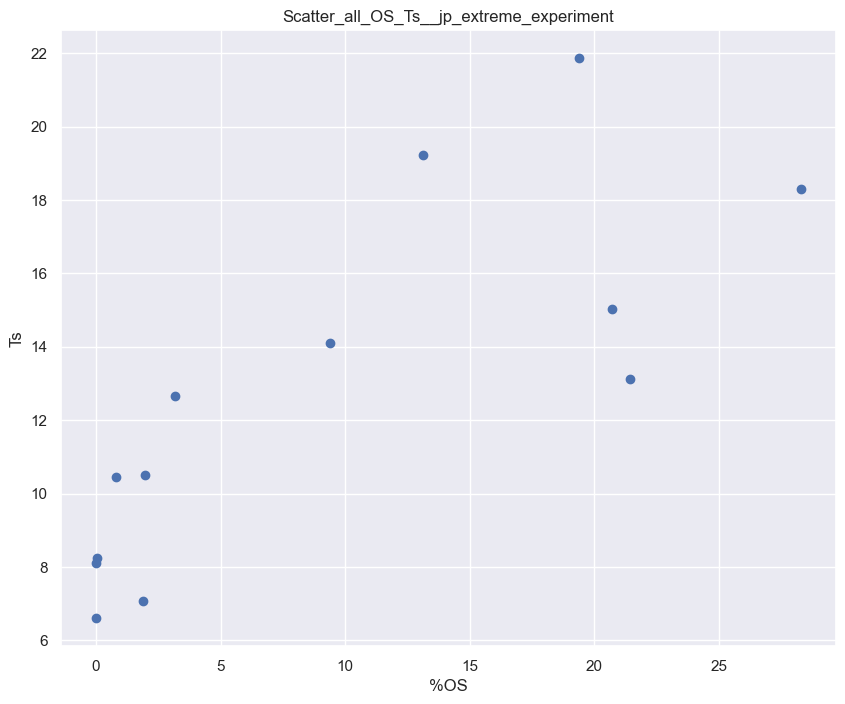

In [118]:
scatter_plotting(filtered_speedup_properties, save_path, title="Scatter_all_OS_Ts_"+output_postfix, 
parameter1=1, parameter2=2, parameter1_name="%OS", parameter2_name="Ts")

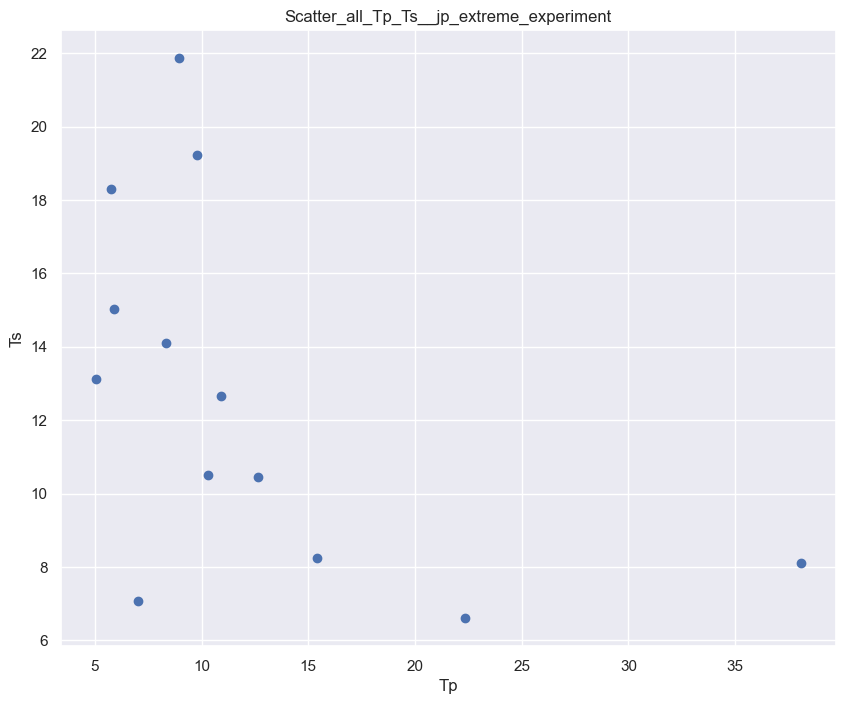

In [119]:
scatter_plotting(filtered_speedup_properties, save_path, title="Scatter_all_Tp_Ts_"+output_postfix, 
parameter1=0, parameter2=2, parameter1_name="Tp", parameter2_name="Ts")

### Scatterplots

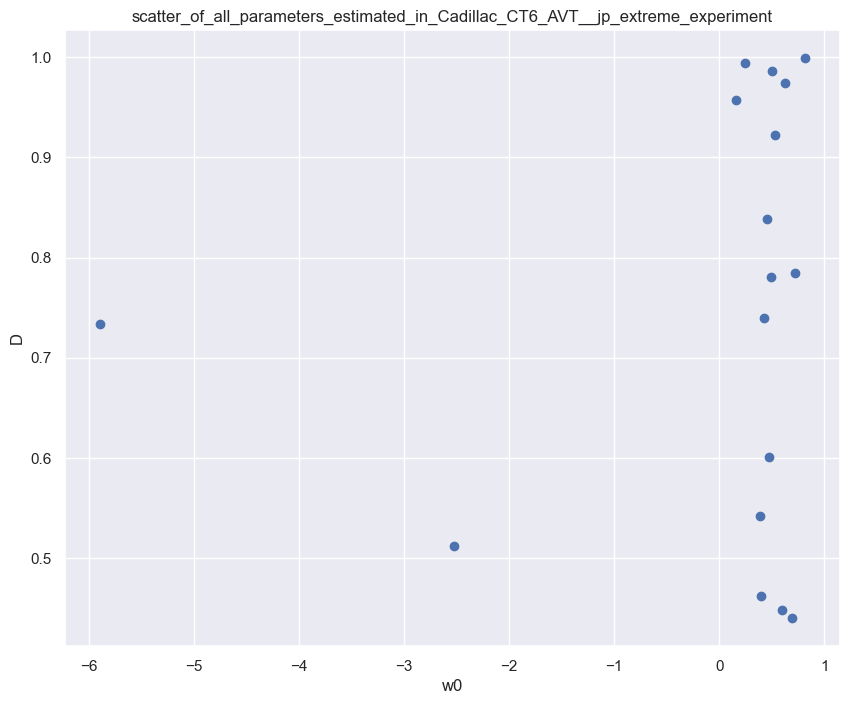

In [120]:
title = "scatter_of_all_parameters_estimated_in_Cadillac_CT6_AVT_" + output_postfix 
scatter_plotting(speedup_parameters, save_path, title)

### KMeans

(13, 2)
Cluster Centers Tp : [ 7.09478369 10.77701113 30.19669933]
Cluster Centers: %OS : [2.05899023e+01 2.87983856e+00 6.68375937e-05]


c:\Users\scs3yh\.conda\envs\geoenv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


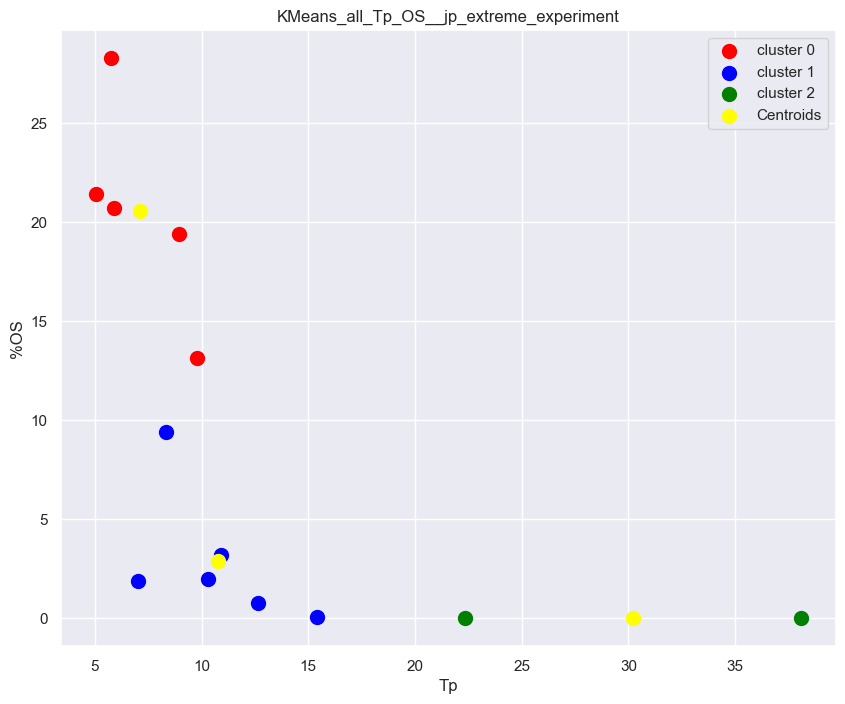

KMeans(init='random', n_clusters=3, n_init=3, random_state=696969)

In [121]:
k_means_scatter(filtered_speedup_properties, 3,seed, title="KMeans_all_Tp_OS_"+output_postfix, save_path=save_path,
parameter1=0, parameter2=1, parameter1_name="Tp", parameter2_name="%OS", show_fig=True)

(13, 2)
Cluster Centers OS : [20.58990228  6.28808856  0.78383132]
Cluster Centers: Ts : [17.51052554 13.38211822  8.49623537]


c:\Users\scs3yh\.conda\envs\geoenv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


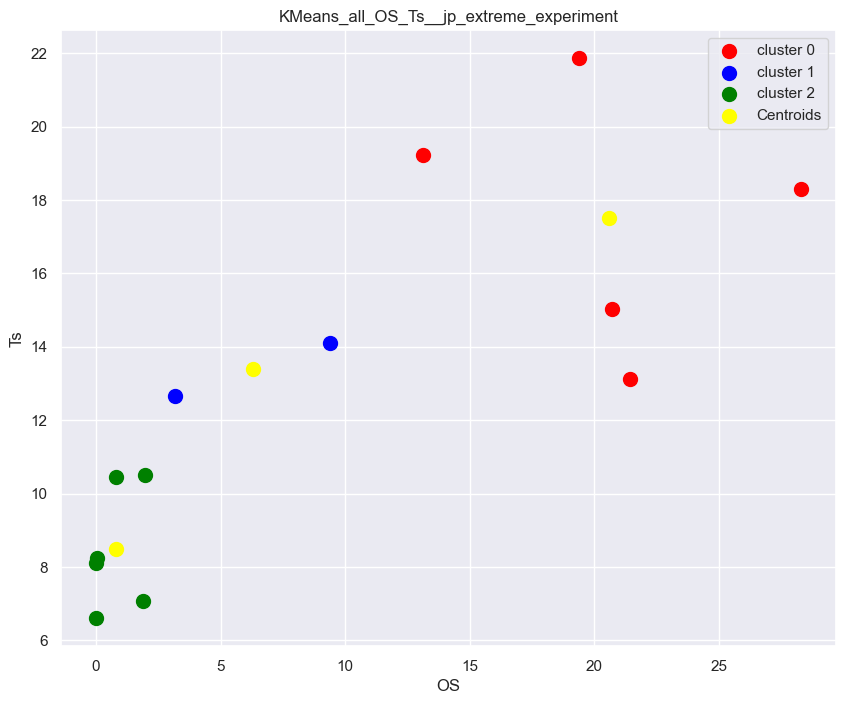

KMeans(init='random', n_clusters=3, n_init=3, random_state=696969)

In [122]:
k_means_scatter(filtered_speedup_properties, 3,seed, title="KMeans_all_OS_Ts_"+output_postfix, save_path=save_path,
parameter1=1, parameter2=2, parameter1_name="OS", parameter2_name="Ts", show_fig=True)

(13, 2)
Cluster Centers Tp : [ 7.30103221 11.26595839 30.19669933]
Cluster Centers: Ts : [16.94190234  9.7893256   7.34811717]


c:\Users\scs3yh\.conda\envs\geoenv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


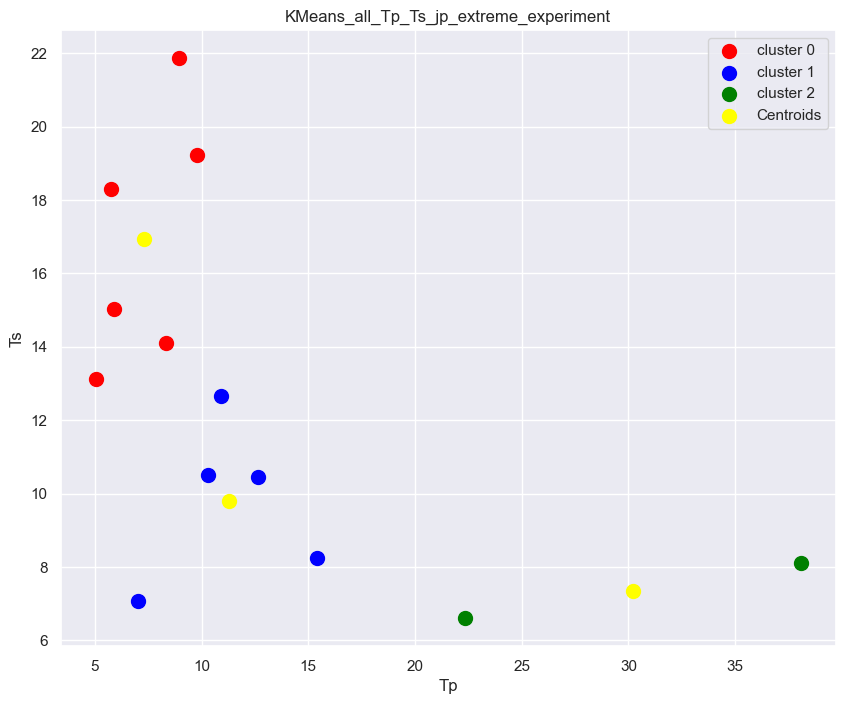

KMeans(init='random', n_clusters=3, n_init=3, random_state=696969)

In [123]:
k_means_scatter(filtered_speedup_properties, 3,seed, title="KMeans_all_Tp_Ts"+output_postfix, save_path=save_path,
parameter1=0, parameter2=2, parameter1_name="Tp", parameter2_name="Ts", show_fig=True)

## Per Driver

In [124]:
unique_drivers = list(set(list(parameters_df["driver_id"])))